# Fine Tuning BERT for Sentiment Analysis with PyTorch

References:
- [Fine Tuning BERT for Sentiment Analysis with PyTorch](https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/)
- [Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

- [RuntimeError: CUDA out of memory during loss.backward()](https://discuss.pytorch.org/t/runtimeerror-cuda-out-of-memory-during-loss-backward/53450/6)
- [Forms - Colaboratory](https://colab.research.google.com/notebooks/forms.ipynb)
- [Plotting loss curve](https://discuss.pytorch.org/t/plotting-loss-curve/42632/5)
- [Estratégias eficazes para lidar com conjuntos de dados desbalanceados](https://medium.com/@daniele.santiago/estrat%C3%A9gias-eficazes-para-lidar-com-conjuntos-de-dados-desbalanceados-5b873894483b)
- [Aprenda a balancear seus dados com Undersampling e Oversampling em Python](https://medium.com/@daniele.santiago/aprenda-a-balancear-seus-dados-com-undersampling-e-oversampling-em-python-6fd87095d717#:~:text=J%C3%A1%20o%20over%2Dsampling%2C%20por,t%C3%A9cnicas%20foi%20explicitada%20neste%20artigo.)
- [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample)
- [REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html)

In [1]:
# @title Environment running
running_local = False
if running_local:
    running_colab = running_kaggle = False
else:
    running_colab = False  # @param {type:"boolean"}
    running_kaggle = not running_colab  # @param {type:"boolean"}

In [2]:
if running_colab:
    from google.colab import drive

    drive.mount("/content/drive")

## Installing and Importing Required Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

## Config

In [4]:
RANDOM_SEED = 103
TEST_SIZE = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5

TOKEN_MAX_LENGTH = 512
MODEL_PATH = "neuralmind/bert-base-portuguese-cased"

SAMPLE_REVIEWS = [
    "Empresa boa para trabalhar", # positive
    "Empresa ruim para trabalhar", # negative
    "Não tenho o que declarar", # neutral
]


if running_colab:
    GLASSDOOR_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-dropout-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-dropout-freezing-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/"
if running_kaggle:
    GLASSDOOR_MODEL_PATH = "/kaggle/working/bertimbau-glassdoor-reviews-dropout-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = (
        "/kaggle/working/bertimbau-glassdoor-reviews-dropout-freezing-epoch_5.bin"
    )
    PATH_TO_SAVE_MODEL = "/kaggle/working/"
if running_local:
    GLASSDOOR_MODEL_PATH = "./bertimbau-glassdoor-reviews-dropout-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = "./bertimbau-glassdoor-reviews-dropout-freezing-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "./train_model/"

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


In [6]:
torch.manual_seed(RANDOM_SEED)

In [7]:
random.seed(RANDOM_SEED)

In [8]:
np.random.seed(RANDOM_SEED)

## Importing and Preprocessing the Dataset

In [9]:
if running_colab:
    dataset = pd.read_csv(
        "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/data_preparation/glassdoor_reviews_annotated.csv"
    )
else:
    if running_kaggle:
        dataset = pd.read_csv(
            "/kaggle/input/glassdoor-reviews-annotated2/glassdoor_reviews_annotated.csv"
        )
    else:
        dataset = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [10]:
dataset.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1


In [11]:
filtered_dataset = dataset.filter(["review_text", "sentiment"])

In [12]:
filtered_dataset.shape

(2532, 2)

In [13]:
filtered_dataset["sentiment"].value_counts()

sentiment
 1    1269
-1    1021
 0     242
Name: count, dtype: int64

In [14]:
num_labels = len(filtered_dataset["sentiment"].value_counts())

In [15]:
num_labels

3

In [16]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,-1
4,Única vantagem era o trabalho ser home office,0


Replace negative sentiment (-1) to 2, to avoid PyTorch errors.

In [17]:
filtered_dataset["sentiment"] = filtered_dataset["sentiment"].apply(
    lambda x: 2 if x == -1 else x
)

In [18]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,2
4,Única vantagem era o trabalho ser home office,0


Shuffle the data before splitting it into training and testing sets to remove any inherent ordering in the data that could bias the model's learning process.

In [19]:
filtered_dataset = filtered_dataset.sample(frac=1, random_state=RANDOM_SEED)

In [20]:
train_data, test_data = train_test_split(
    filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [21]:
train_data.shape

(2025, 2)

In [22]:
test_data.shape

(507, 2)

## Loading Bertimbau model

In [23]:
bertimbau = BertModel.from_pretrained(MODEL_PATH)

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [24]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Create a PyTorch Dataset

In [25]:
class GlassdoorReviewsDataset(Dataset):
    def __init__(self, data, tokenizer, token_max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = token_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["review_text"]
        labels = self.data.iloc[index][["sentiment"]].values.astype(int)

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=False,
            # max_length=self.max_length,
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]

        # resize the tensors to the same size
        input_ids = nn.functional.pad(
            input_ids, (0, self.max_length - input_ids.shape[0]), value=0
        )
        attention_mask = nn.functional.pad(
            attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0
        )

        return input_ids, attention_mask, torch.tensor(labels)

In [26]:
train_dataset = GlassdoorReviewsDataset(train_data, tokenizer, TOKEN_MAX_LENGTH)
test_dataset = GlassdoorReviewsDataset(test_data, tokenizer, TOKEN_MAX_LENGTH)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating a PyTorch Model

In [28]:
classifier = nn.Sequential(
    nn.Linear(bertimbau.config.hidden_size, 300),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, num_labels),
)

In [29]:
class GlassdoorReviewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_PATH)
        self.classifier = classifier


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

In [30]:
class GlassdoorReviewsClassifierFreezing(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifierFreezing, self).__init__()

        for param in bertimbau.parameters():
            param.requires_grad = False

        self.bert = BertModel.from_pretrained(MODEL_PATH)
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

## Model training functions

In [31]:
def train(model, data_loader, loss_fun, optimizer, n_total_steps):
    model.train()

    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        loss = loss_fun(logits, labels)

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if (i + 1) % BATCH_SIZE == 0:
            print(
                f"Training Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
            )

    return running_loss / len(data_loader)

In [32]:
def test(model, data_loader, loss_fun, n_total_steps):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fun(logits, labels)

            loss_value = loss.item()
            running_loss += loss_value

            if (i + 1) % BATCH_SIZE == 0:
                print(
                    f"Evaluating Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
                )

    return running_loss / len(data_loader)

In [33]:
def show_loss(train_loss_per_epoch, test_loss_per_epoch, title):
    epochs = range(1, len(train_loss_per_epoch) + 1)

    train_data = {"epoch": epochs, "loss": train_loss_per_epoch, "type": "Train"}
    test_data = {"epoch": epochs, "loss": test_loss_per_epoch, "type": "Test"}
    df_loss = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_loss, x="epoch", y="loss", hue="type", marker="o")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # plt.grid(True)
    plt.legend(title="Loss Type")
    plt.show()

In [34]:
def start_training(model, train_loader, loss_fun, optimizer, epochs, n_total_steps):
    train_losses = []
    test_losses = []

    for t in range(epochs):
        print(f"{'-'*20} Epoch: {t + 1}/{epochs} {'-'*20}")

        train_loss = train(model, train_loader, loss_fun, optimizer, n_total_steps)
        train_losses.append(train_loss)

        print("")

        test_loss = test(model, test_loader, loss_fun, n_total_steps)
        test_losses.append(test_loss)

        print(f"\nTrain Loss: {train_loss}, \t\t Test Loss: {test_loss}")
        print("\n\n")

    return train_losses, test_losses

## Model Evaluation functions

In [35]:
def evaluate_model(model, test_loader, device):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [36]:
def show_confusion_matrix(all_labels, all_preds, normalize=None):
    cm = confusion_matrix(all_labels, all_preds, normalize=normalize)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [37]:
def predict_reviews(model, reviews) -> None:
    class_names = ["neutral", "positive", "negative"]
    for review in reviews:
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=TOKEN_MAX_LENGTH,
            add_special_tokens=True,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = encoded_review["input_ids"].to(device)
        attention_mask = encoded_review["attention_mask"].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        probs = nn.functional.softmax(output, dim=1)

        print(f"Review text: {review}")
        # print(probs)
        print(pd.DataFrame(probs.tolist()[0], class_names)[0])
        print("\n")

    return None

## Training the Model (without oversampling)

In [38]:
model = GlassdoorReviewsClassifier(num_labels).to(device)
model_freezing = GlassdoorReviewsClassifierFreezing(num_labels).to(device)

In [39]:
loss_fun = nn.CrossEntropyLoss()

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer_freezing = torch.optim.Adam(model_freezing.parameters(), lr=LEARNING_RATE)

In [41]:
n_total_steps = len(train_loader)
n_total_steps

127

### Training Model without freezing BERT Layers

In [42]:
train_losses, test_losses = start_training(
    model, train_loader, loss_fun, optimizer, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 0.9964
Training Batch 32/127, 		 loss = 0.8871
Training Batch 48/127, 		 loss = 0.6858
Training Batch 64/127, 		 loss = 0.6405
Training Batch 80/127, 		 loss = 0.4656
Training Batch 96/127, 		 loss = 0.4385
Training Batch 112/127, 		 loss = 0.3730

Evaluating Batch 16/127, 		 loss = 0.4622
Evaluating Batch 32/127, 		 loss = 0.1587

Train Loss: 0.6152298803639225, 		 Test Loss: 0.28420103155076504



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 0.1666
Training Batch 32/127, 		 loss = 0.3016
Training Batch 48/127, 		 loss = 0.3793
Training Batch 64/127, 		 loss = 0.0830
Training Batch 80/127, 		 loss = 0.4452
Training Batch 96/127, 		 loss = 0.0969
Training Batch 112/127, 		 loss = 0.2167

Evaluating Batch 16/127, 		 loss = 0.2766
Evaluating Batch 32/127, 		 loss = 0.0511

Train Loss: 0.2339029794954878, 		 Test Loss: 0.22014187683817



-------------------- Epoc

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

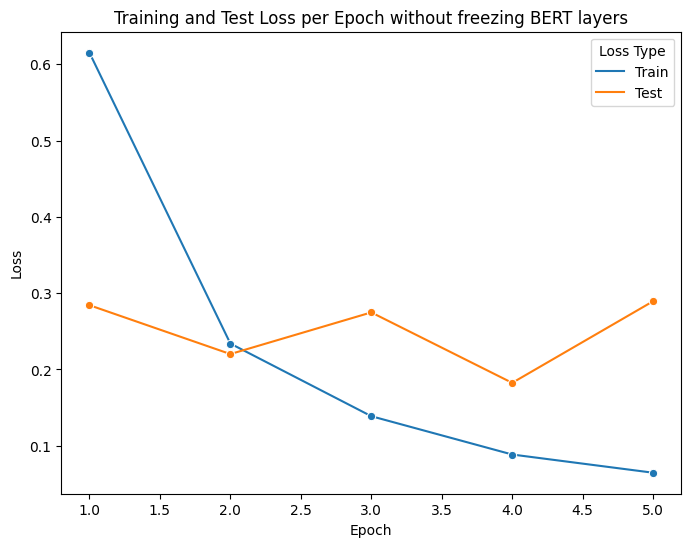

In [43]:
show_loss(train_losses, test_losses, title="Training and Test Loss per Epoch without freezing BERT layers")

#### Evaluating the Model

In [44]:
all_labels, all_preds = evaluate_model(model, test_loader, device)

In [45]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.83      0.75      0.78        51
           1       0.92      0.97      0.94       269
           2       0.96      0.90      0.93       187

    accuracy                           0.92       507
   macro avg       0.90      0.87      0.89       507
weighted avg       0.92      0.92      0.92       507



In [46]:
print(accuracy_score(all_labels, all_preds))

0.9230769230769231


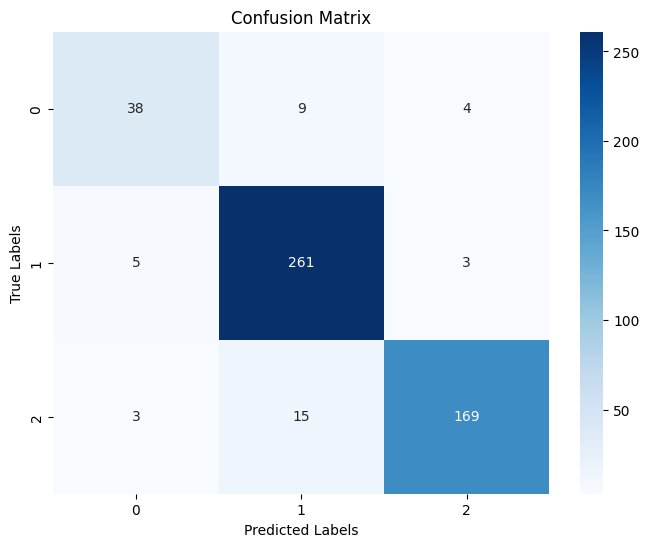

In [47]:
show_confusion_matrix(all_labels, all_preds)

In [48]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

#### Saving the model

In [51]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-dropout-epoch_{EPOCHS}.bin")

#### Loading the model

In [52]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))
loaded_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

#### Sample prediction

In [53]:
predict_reviews(model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.003793
positive    0.992629
negative    0.003577
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.002371
positive    0.002949
negative    0.994680
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.972753
positive    0.015823
negative    0.011424
Name: 0, dtype: float64




### Training Model freezing BERT Layers

In [54]:
train_losses, test_losses = start_training(
    model_freezing, train_loader, loss_fun, optimizer_freezing, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 0.6422
Training Batch 32/127, 		 loss = 0.1998
Training Batch 48/127, 		 loss = 0.2607
Training Batch 64/127, 		 loss = 0.4869
Training Batch 80/127, 		 loss = 0.1908
Training Batch 96/127, 		 loss = 0.0495
Training Batch 112/127, 		 loss = 0.4210

Evaluating Batch 16/127, 		 loss = 0.2456
Evaluating Batch 32/127, 		 loss = 0.0528

Train Loss: 0.3746467780351169, 		 Test Loss: 0.2021959408884868



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 0.4736
Training Batch 32/127, 		 loss = 0.1103
Training Batch 48/127, 		 loss = 0.0227
Training Batch 64/127, 		 loss = 0.0773
Training Batch 80/127, 		 loss = 0.2549
Training Batch 96/127, 		 loss = 0.0606
Training Batch 112/127, 		 loss = 0.0519

Evaluating Batch 16/127, 		 loss = 0.1497
Evaluating Batch 32/127, 		 loss = 0.0207

Train Loss: 0.16131832187364656, 		 Test Loss: 0.16284750238992274



-------------------- E

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

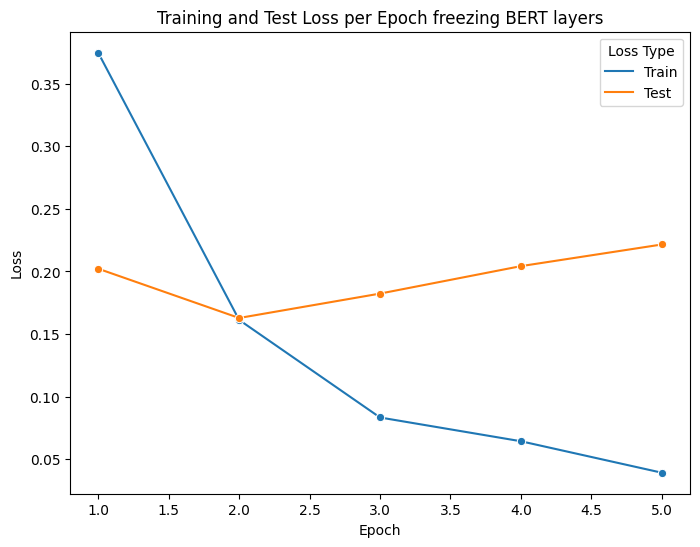

In [55]:
show_loss(train_losses, test_losses, title="Training and Test Loss per Epoch freezing BERT layers")

#### Evaluating the Model

In [56]:
all_labels, all_preds = evaluate_model(model_freezing, test_loader, device)

In [57]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85        51
           1       0.95      0.97      0.96       269
           2       0.94      0.95      0.95       187

    accuracy                           0.94       507
   macro avg       0.94      0.91      0.92       507
weighted avg       0.94      0.94      0.94       507



In [58]:
print(accuracy_score(all_labels, all_preds))

0.9447731755424064


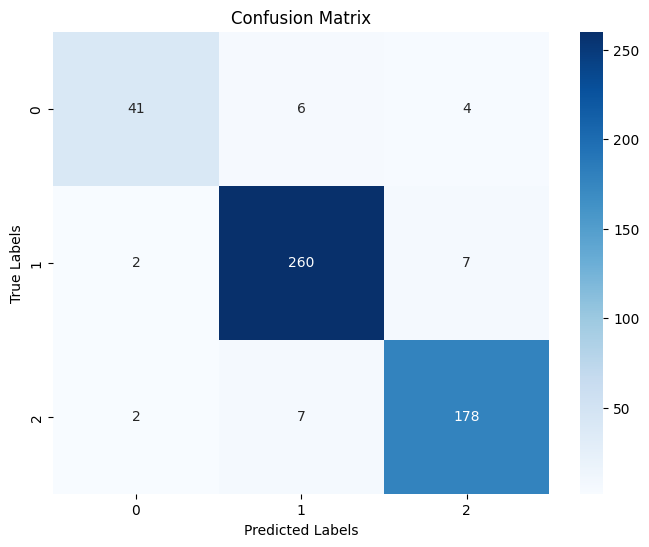

In [59]:
show_confusion_matrix(all_labels, all_preds)

In [60]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

#### Saving the model

In [61]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-dropout-freezing-epoch_{EPOCHS}.bin")

#### Loading the model

In [62]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_FREEZING_MODEL_PATH, map_location=device))
loaded_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

##### Sample prediction

In [63]:
predict_reviews(loaded_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000469
positive    0.999116
negative    0.000415
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.000388
positive    0.000393
negative    0.999220
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.995772
positive    0.002342
negative    0.001886
Name: 0, dtype: float64




## Training the model (with oversampling)

### Oversampling

In [64]:
def oversampling(train_df, minority_class=0, majority_classes=[1, 2]):
    # Desired number of samples for the minority class
    oversample_size = (
        train_df[train_df["sentiment"] == 0]["sentiment"].value_counts()[0] * 3
    )

    oversampler = RandomOverSampler(sampling_strategy={minority_class: oversample_size})
    X_res, y_res = oversampler.fit_resample(
        train_df[["review_text"]], train_df["sentiment"]
    )

    y_res_df = pd.DataFrame({"sentiment": y_res})
    resampled_df = pd.concat([X_res, y_res_df], axis=1)
    resampled_df.reset_index(drop=True, inplace=True)

    resampled_minority_df = resampled_df[resampled_df["sentiment"] == minority_class]

    # Concatenate the oversampled minority class with the majority class
    oversampled_df = pd.concat([train_df, resampled_minority_df])

    # Shuffle the DataFrame to randomize the order of samples
    oversampled_df = oversampled_df.sample(
        frac=1, random_state=RANDOM_SEED
    ).reset_index(drop=True)
    return oversampled_df

In [65]:
filtered_dataset.shape

(2532, 2)

In [66]:
filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     242
Name: count, dtype: int64

In [67]:
oversampled_filtered_dataset = oversampling(filtered_dataset)

In [68]:
oversampled_filtered_dataset.shape

(3258, 2)

In [69]:
oversampled_filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     968
Name: count, dtype: int64

### Training the Model

In [70]:
oversampled_train_data, oversampled_test_data = train_test_split(
    oversampled_filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [71]:
oversampled_train_dataset = GlassdoorReviewsDataset(
    oversampled_train_data, tokenizer, TOKEN_MAX_LENGTH
)

oversampled_test_dataset = GlassdoorReviewsDataset(
    oversampled_test_data, tokenizer, TOKEN_MAX_LENGTH
)

In [72]:
oversampled_train_loader = DataLoader(
    oversampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
oversampled_test_loader = DataLoader(
    oversampled_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [73]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model_freezing = GlassdoorReviewsClassifierFreezing(num_labels).to(device)

In [74]:
loss_fun = nn.CrossEntropyLoss()

In [75]:
oversampled_optimizer = torch.optim.Adam(
    oversampled_model.parameters(), lr=LEARNING_RATE
)
oversampled_optimizer_freezing = torch.optim.Adam(
    oversampled_model_freezing.parameters(), lr=LEARNING_RATE
)

In [76]:
n_total_steps = len(oversampled_train_loader)
n_total_steps

163

#### Train without freezing

In [78]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 67.06 MiB is free. Process 3845 has 14.68 GiB memory in use. Of the allocated memory 14.09 GiB is allocated by PyTorch, and 467.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

##### Evaluating the Model

In [ ]:
len(oversampled_train_losses)

In [ ]:
len(oversampled_test_losses)

In [ ]:
show_loss(oversampled_train_losses, oversampled_test_losses, title="Oversampled Training and Test Loss per Epoch without freezing BERT layers")

In [ ]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model, oversampled_test_loader, device
)

In [ ]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

In [ ]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

In [ ]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

##### Saving the model

In [ ]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-dropout-oversampled-epoch_{EPOCHS}.bin",
)

##### Loading the model

In [ ]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-epoch_5.bin",
            f"bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

##### Sample prediction

In [ ]:
predict_reviews(oversampled_model, SAMPLE_REVIEWS)

#### Train freezing

In [ ]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model_freezing,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer_freezing,
    EPOCHS,
    n_total_steps,
)

##### Evaluating the Model

In [ ]:
len(oversampled_train_losses)

In [ ]:
len(oversampled_test_losses)

In [ ]:
show_loss(
    oversampled_train_losses,
    oversampled_test_losses,
    title="Oversampled Training and Test Loss per Epoch freezing BERT layers",
)

In [ ]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model_freezing, oversampled_test_loader, device
)

In [ ]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

In [ ]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

In [ ]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

##### Saving the model

In [ ]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-dropout-oversampled-freezing-epoch_{EPOCHS}.bin",
)

##### Loading the model

In [ ]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-epoch_5.bin",
            f"bertimbau-glassdoor-reviews-dropout-oversampled-freezing-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

##### Sample prediction

In [ ]:
predict_reviews(oversampled_model, SAMPLE_REVIEWS)